In [4]:
#Install required Libraries
!pip install -qq -U diffusers transformers ftfy gradio accelerate

In [5]:
#Import libraries
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-05-28 06:36:02.285328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 06:36:02.285459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 06:36:02.402204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
#Import the model
device = "cuda"
model_path = "stabilityai/stable-diffusion-2-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
#Function to visualize image after generation
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


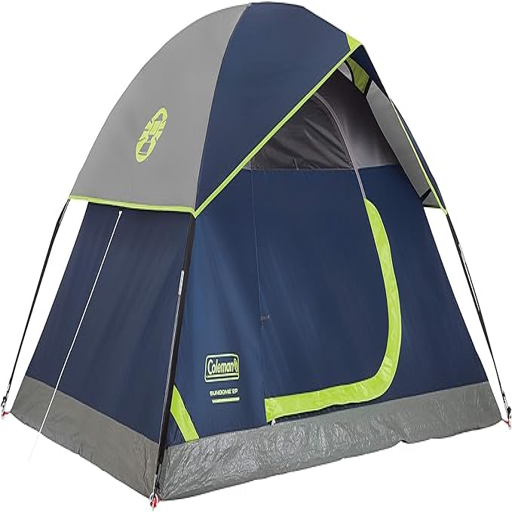

In [59]:
# Update the paths as necessary
image_path = "/kaggle/input/objects-with-white-background/examples/example5.jpg"
image = PIL.Image.open(image_path).resize((512, 512))
image

In [60]:
#Function to generate the mask for inpainting

import cv2
import numpy as np

def generate_mask(image_path):
  image = cv2.imread(image_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  binary = cv2.bitwise_not(binary)
  kernel = np.ones((5, 5), np.uint8)
  binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
  binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
  binary = cv2.bitwise_not(binary)

  cv2.imwrite('/kaggle/working/mask_image.png', binary)

generate_mask(image_path)

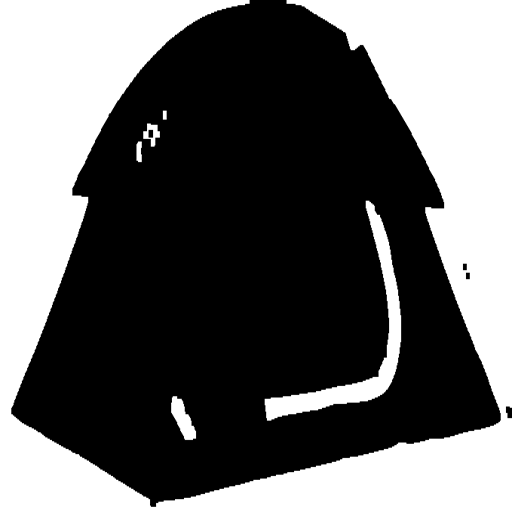

In [61]:
# update the paths for mask_image in above cell and present cell
mask_path = "/kaggle/working/mask_image.png"
mask_image = PIL.Image.open(mask_path).resize((512, 512))
mask_image

In [62]:
# Make sure the image is of type RGB
image = image.convert("RGB")
mask_image = mask_image.convert("RGB")

In [63]:
#Add padding to increase the background space
from PIL import Image

def add_padding(image):
  new_size = (1024, 1024)
  new_image = Image.new("RGB", new_size, "white")
  x_offset = (new_size[0] - image.width) // 2
  y_offset = (new_size[1] - image.height) // 2
  new_image.paste(image, (x_offset, y_offset))
  new_size = (512, 512)
  resized_image = new_image.resize(new_size)
  return resized_image

image = add_padding(image)
mask_image = add_padding(mask_image)

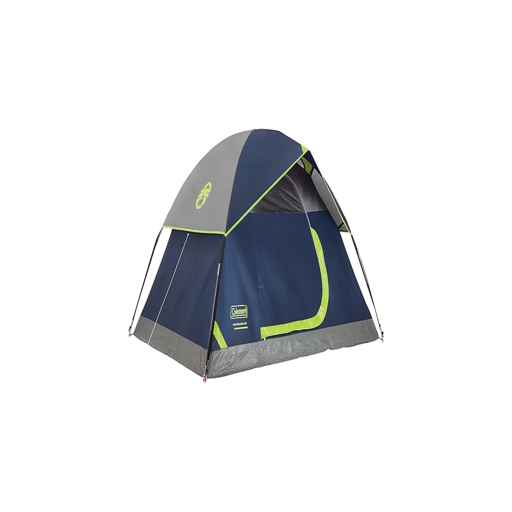

In [64]:
image

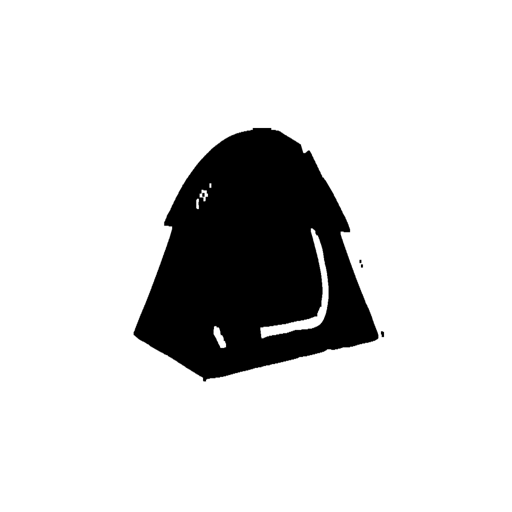

In [65]:
mask_image

In [66]:
#Run the inference
prompt = "camping tent in the forest"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

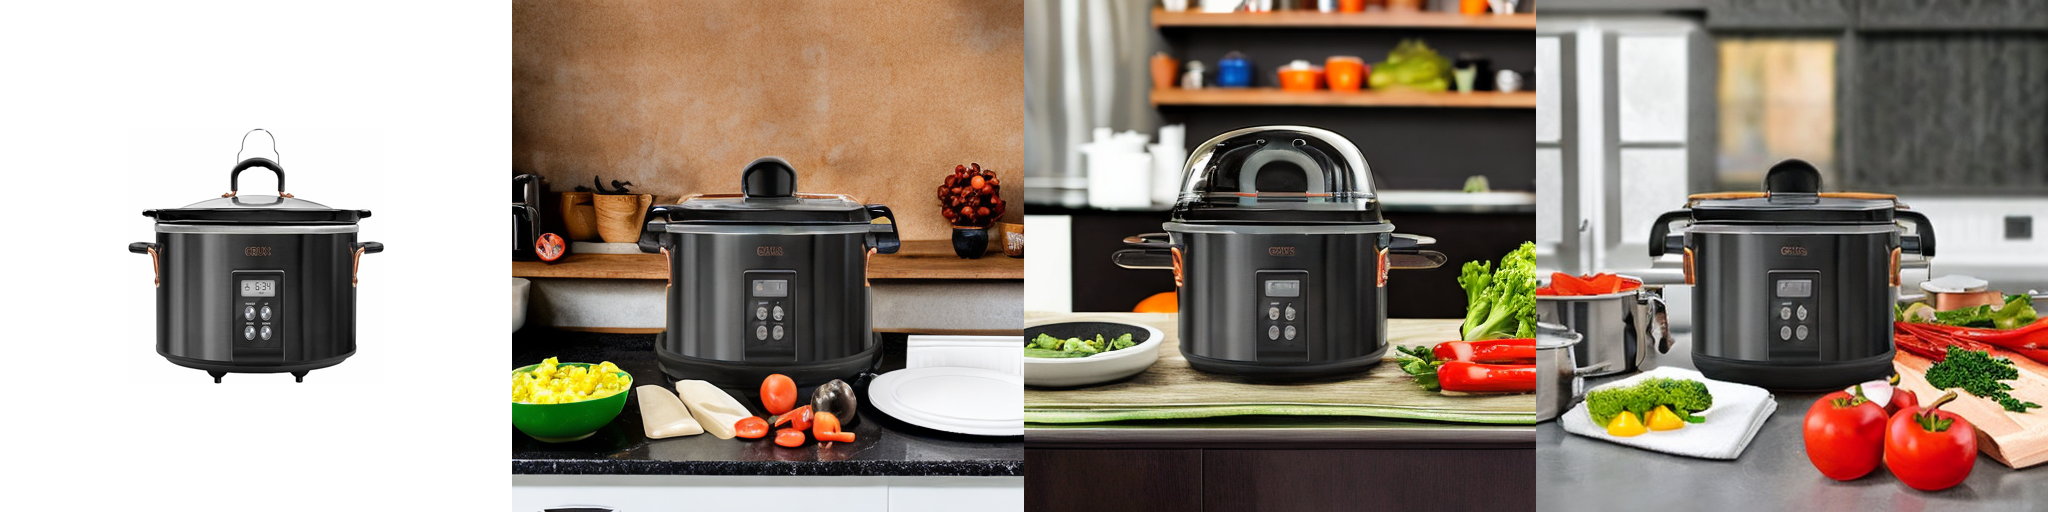

In [20]:
# Example image1
images.insert(0, image)
image_grid(images, 1, num_samples + 1)

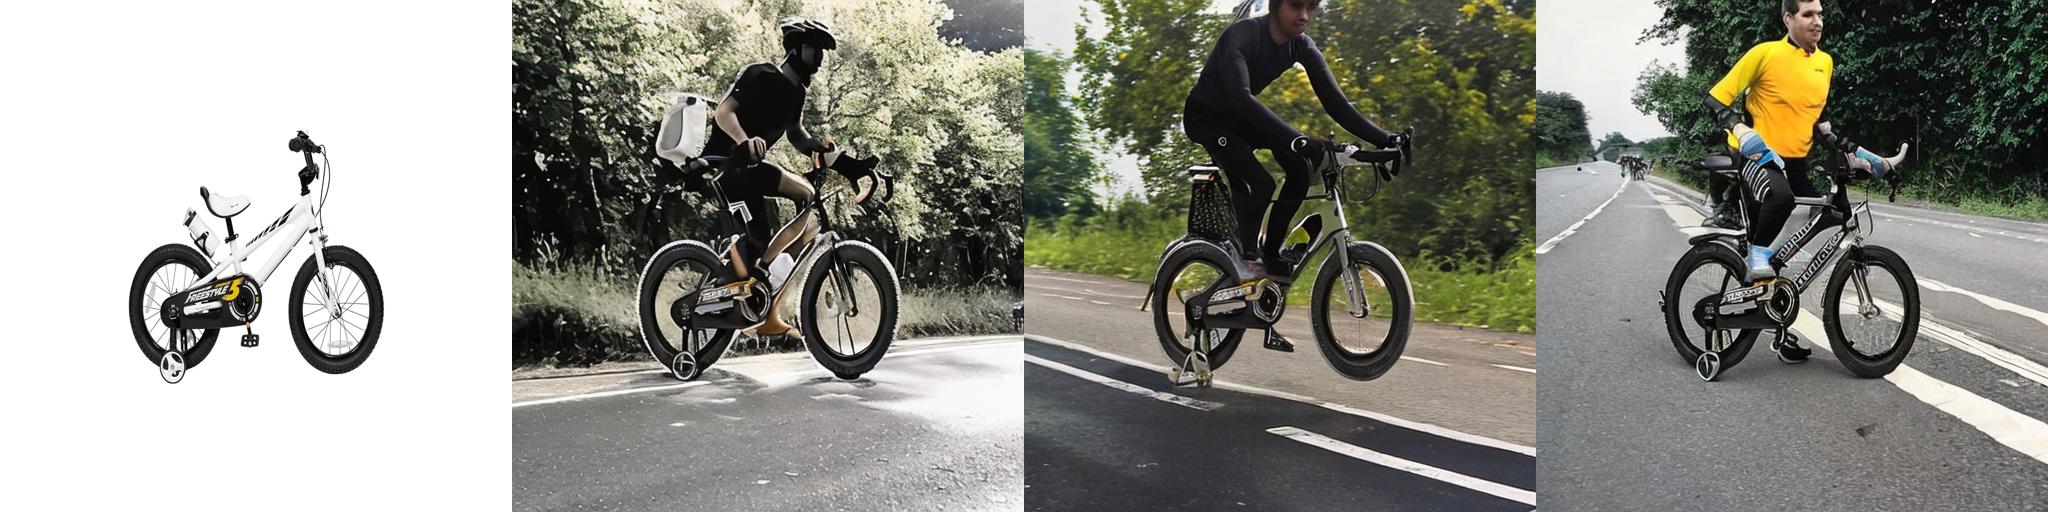

In [38]:
# Example image2
images.insert(0, image)
image_grid(images, 1, num_samples + 1)

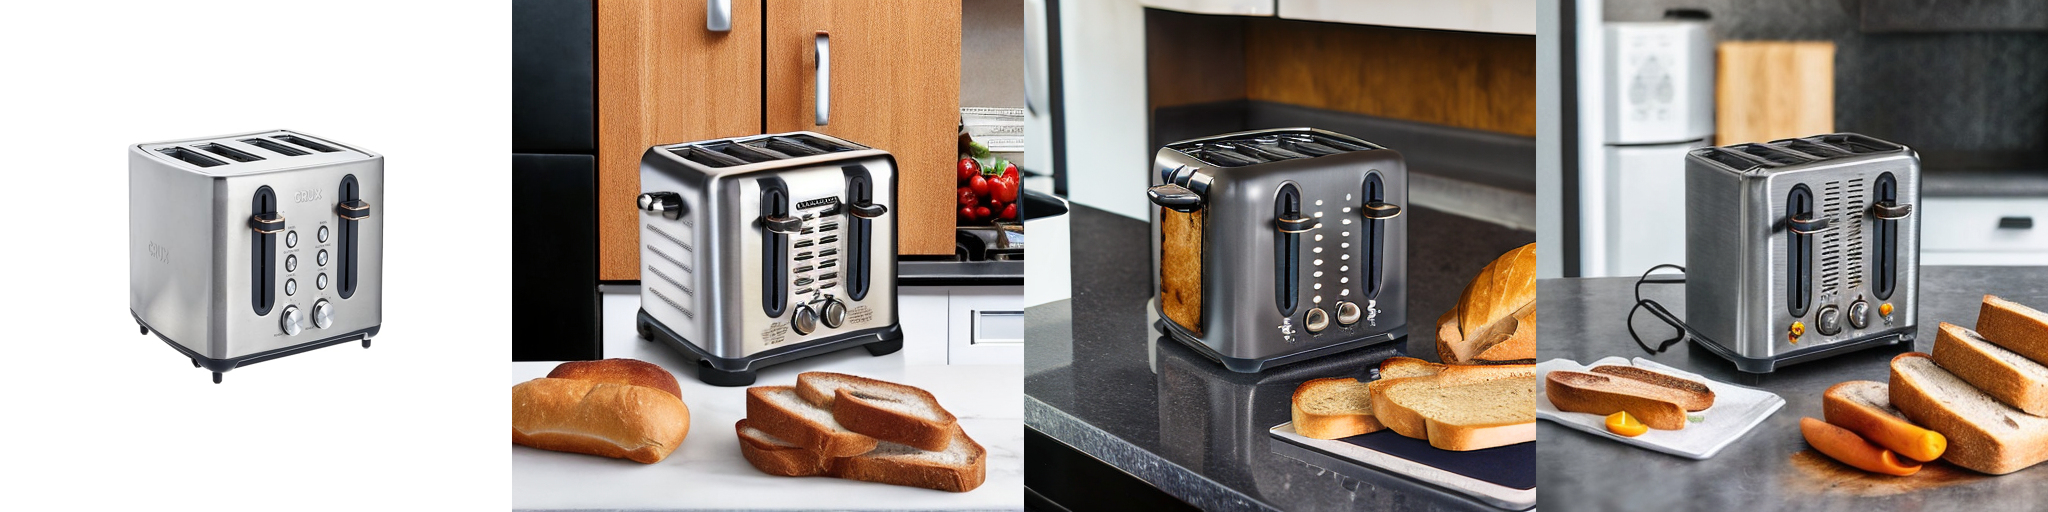

In [48]:
# Example image3
images.insert(0, image)
image_grid(images, 1, num_samples + 1)

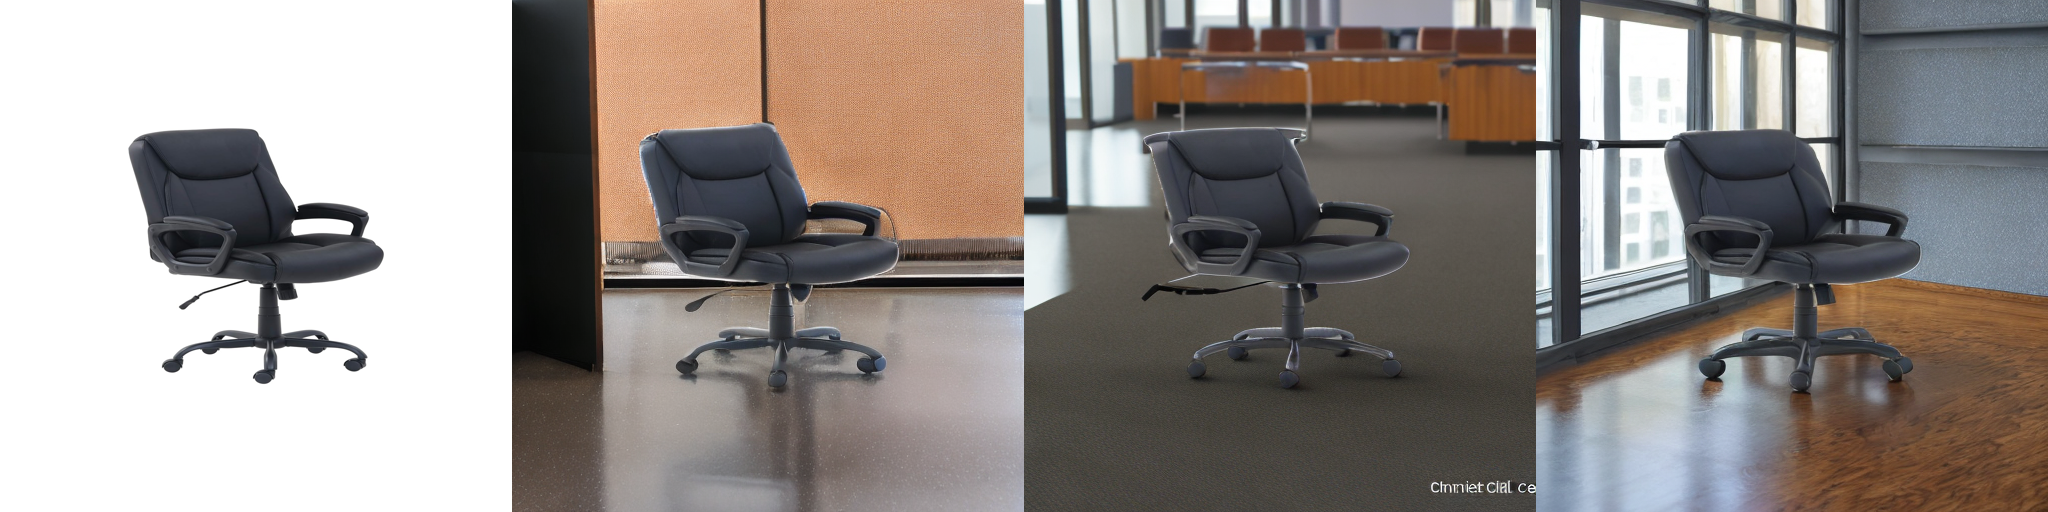

In [58]:
# Example image4
images.insert(0, image)
image_grid(images, 1, num_samples + 1)

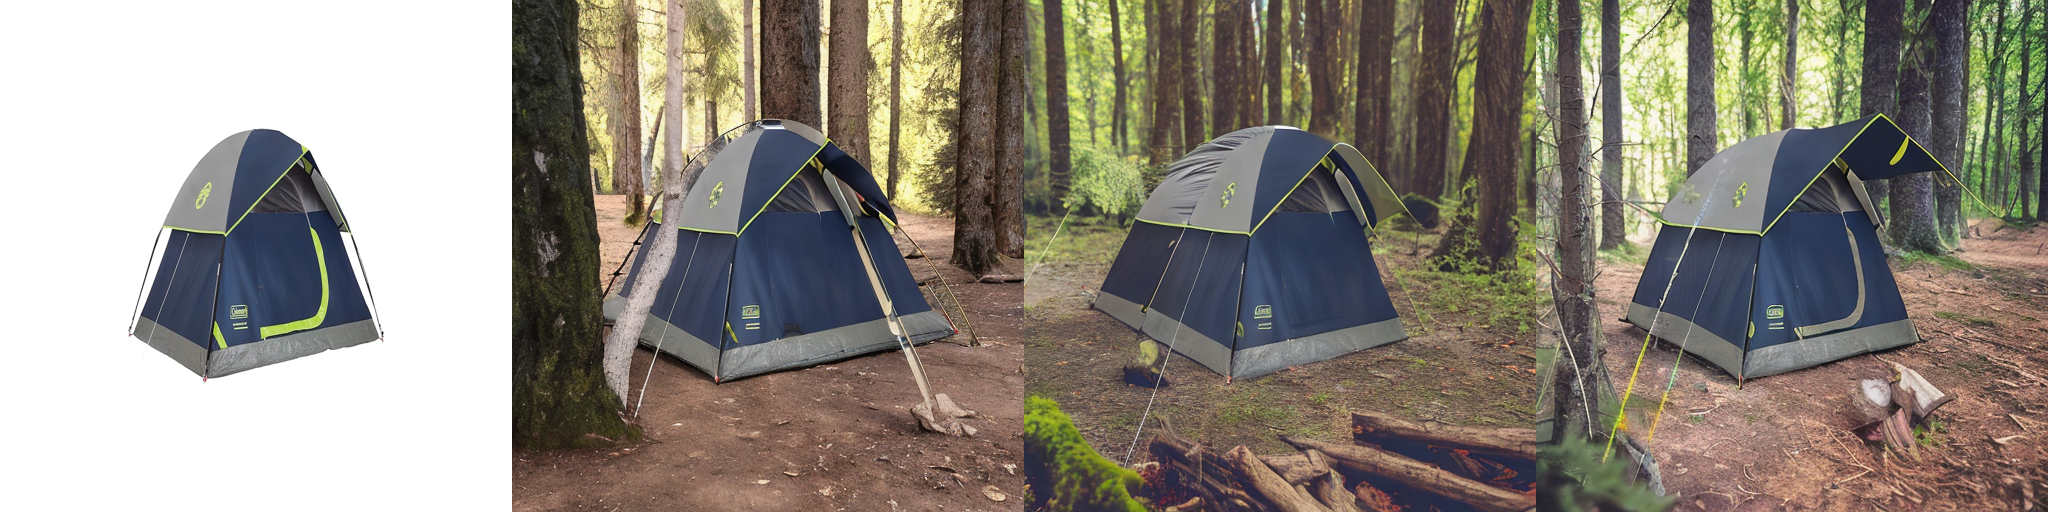

In [67]:
# Example image5
images.insert(0, image)
image_grid(images, 1, num_samples + 1)